## Conv4_3D_res_v2
* key features
    * 4-20 Conv layers
        * 2 residual parts of (Convolution block + 2 Identity blocks)
    * 2 dropout layers (rate=0.7) + 2 dropout (rate=0.4) after residual Convs
    * SWISH activation functions
    * Nadam optimizer
    * 6 models trained on 6 different subsets of data for systematic error analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.constraints import MaxNorm

import tensorflow as tf
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

tf.logging.set_verbosity(tf.logging.ERROR)
K.get_session().list_devices()

Using TensorFlow backend.


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 5382446467211339377),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13365853574227242225),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11261403663061655131),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 7925845197, 1759520634232865640)]

In [2]:
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices() if "GPU" in d.name]

['XLA_GPU 16384 Mb', 'GPU 7558 Mb']

In [3]:
#from tensorflow.python.client import device_lib
# TensorFlow wizardry
#config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

In [4]:
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)
# adding a custom activation function
get_custom_objects().update({'swish': swish})


def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv3D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('swish')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv3D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('swish')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('swish')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv3D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a SWISH activation (≈2 lines)
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('swish')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_3d_model(input_shape=(32,32,8,1)):
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='swish', name='conv1_2')(X)
    X = MaxPooling3D(name='pool1')(X)
    #print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.3, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    #print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = MaxPooling3D(padding='same', name='pool3')(X)
    #print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

In [5]:
def train_gen(augen):
    for x_tmp, y_tmp in augen:
        yield np.reshape(x_tmp, (*x_tmp.shape, 1)), y_tmp

In [6]:
X, y, shuffs = {},{},{}
conv4_3d_res, hist_roc, hist = {},{},{}
class_names = ['C100keV', 'C60keV', 'C30keV']
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'
nadamka = optimizers.Nadam(lr=1e-4, beta_1=0.95)
N_ep = 15; batch = 256; i=0; n_fold = 4
load_s = []
for n in class_names:
    load_s += [(n,str(i)) for i in range(1,n_fold+1)]
print('Training in ',n_fold,' folds for ',N_ep,' epochs with batch_size =',batch)
print('The optimizer is Nadam:\n\tinitial lr =',K.eval(nadamka.lr),'\tbeta_1 =',K.eval(nadamka.beta_1),
      '\tbeta_2 =',K.eval(nadamka.beta_2),'\n')

start = datetime.now()
for s, p in load_s:
    if not s in X.keys():
        print('\n\tFor validation on '+s+' vs gamma')
        X[s], y[s], shuffs[s] = load_data_v2(classes={'s_'+s:'full', 'b_gamma':'full'}, tr_val_test=[False,True,False],
                                             im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1, stratify=True)
        i=0; print('')
    i+=1; print('FOLD '+str(i)+':\t'+s+' part '+p+'/'+str(n_fold)+' vs gamma part '+p+'/'+str(n_fold))
    fold = datetime.now()
    X[s+p], y[s+p], shuffs[s+p] = load_data_v2(classes={'s_'+s:p, 'b_gamma':p}, n_folds=n_fold, tr_val_test=[True,False,False],
                                               im_ft=[True,False], path_h5=dset, shuf_ind={}, verbose=1, ddd=False, stratify=True)
    aug_train = ImageDataGenerator(rotation_range=90, fill_mode='reflect', dtype=float)
    conv4_3d_res[s+p] = conv_res_3d_model(input_shape=(*X[s+p]['/images/train'].shape[1:], 1))
    conv4_3d_res[s+p].compile(optimizer=nadamka, loss='binary_crossentropy')
    hist_roc[s+p] = call_roc_hist()
    hist[s+p] = conv4_3d_res[s+p].fit_generator(train_gen(aug_train.flow(X[s+p]['/images/train'], y[s+p]['/images/train'], batch_size=batch)),
                                  steps_per_epoch=X[s+p]['/images/train'].shape[0]*2//batch, epochs=N_ep, callbacks=[hist_roc[s+p]],
                                  validation_data=(X[s]['/images/val'],y[s]['/images/val']), verbose=1)
    print('\tfold training time ', datetime.now()-fold)
    print('\ttraining loss: ',np.around(hist[s+p].history['loss'][-1],decimals=4),
          '\t validation loss: ',np.around(hist[s+p].history['val_loss'][-1],decimals=4),
          '\tROC AUC: ',np.around(hist_roc[s+p].val_aucs[-1],decimals=4))
    print('')
print('\nTotal training time ', datetime.now()-start)

Training in  4  folds for  15  epochs with batch_size = 256
The optimizer is Nadam:
	initial lr = 7e-05 	beta_1 = 0.95 	beta_2 = 0.999 


	For validation on C100keV vs gamma
Number of val C100keV samples: 	 3089
Number of gamma samples: 	 3089

FOLD 1:	C100keV part 1/4 vs gamma part 1/4
Number of train C100keV samples: 	 18741
Number of gamma samples: 	 18741


/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 206s 706ms/step - loss: 0.9457 - val_loss: 0.8614
Epoch 2/15
292/292 [==============================] - 196s 671ms/step - loss: 0.4269 - val_loss: 0.6393
Epoch 3/15
292/292 [==============================] - 196s 671ms/step - loss: 0.3188 - val_loss: 0.8951
Epoch 4/15
292/292 [==============================] - 196s 672ms/step - loss: 0.2885 - val_loss: 0.2699
Epoch 5/15
292/292 [==============================] - 196s 671ms/step - loss: 0.2755 - val_loss: 0.2669
Epoch 6/15
292/292 [==============================] - 196s 672ms/step - loss: 0.2649 - val_loss: 0.2562
Epoch 7/15
292/292 [==============================] - 196s 671ms/step - loss: 0.2540 - val_loss: 0.4107
Epoch 8/15
292/292 [==============================] - 196s 672ms/step - loss: 0.2523 - val_loss: 0.3507
Epoch 9/15
292/292 [==============================] - 196s 672ms/step - loss: 0.2324 - val_loss: 0.2262
Epoch 10/15
292/292 [==============================] - 196s 672m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 205s 702ms/step - loss: 0.5836 - val_loss: 1.9975
Epoch 2/15
292/292 [==============================] - 197s 674ms/step - loss: 0.3145 - val_loss: 0.4305
Epoch 3/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2822 - val_loss: 0.3641
Epoch 4/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2703 - val_loss: 0.2625
Epoch 5/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2604 - val_loss: 0.2327
Epoch 6/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2549 - val_loss: 0.2448
Epoch 7/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2485 - val_loss: 0.2692
Epoch 8/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2408 - val_loss: 0.2816
Epoch 9/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2352 - val_loss: 0.2006
Epoch 10/15
292/292 [==============================] - 197s 674m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 205s 703ms/step - loss: 0.6063 - val_loss: 1.6793
Epoch 2/15
292/292 [==============================] - 197s 674ms/step - loss: 0.3402 - val_loss: 0.5509
Epoch 3/15
292/292 [==============================] - 197s 674ms/step - loss: 0.3059 - val_loss: 0.2613
Epoch 4/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2868 - val_loss: 0.2609
Epoch 5/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2832 - val_loss: 0.2238
Epoch 6/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2616 - val_loss: 0.2212
Epoch 7/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2509 - val_loss: 0.2219
Epoch 8/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2421 - val_loss: 0.2308
Epoch 9/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2394 - val_loss: 0.2191
Epoch 10/15
292/292 [==============================] - 197s 674m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 207s 707ms/step - loss: 0.6008 - val_loss: 1.6112
Epoch 2/15
292/292 [==============================] - 197s 675ms/step - loss: 0.3355 - val_loss: 0.8902
Epoch 3/15
292/292 [==============================] - 197s 675ms/step - loss: 0.3099 - val_loss: 0.3464
Epoch 4/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2855 - val_loss: 0.3231
Epoch 5/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2673 - val_loss: 0.2124
Epoch 6/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2621 - val_loss: 0.2092
Epoch 7/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2528 - val_loss: 0.2094
Epoch 8/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2460 - val_loss: 0.2027
Epoch 9/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2379 - val_loss: 0.2137
Epoch 10/15
292/292 [==============================] - 197s 675m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 207s 710ms/step - loss: 0.5643 - val_loss: 0.2933
Epoch 2/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2929 - val_loss: 0.2004
Epoch 3/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2484 - val_loss: 0.1816
Epoch 4/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2060 - val_loss: 0.1601
Epoch 5/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1875 - val_loss: 0.2511
Epoch 6/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1756 - val_loss: 0.1467
Epoch 7/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1662 - val_loss: 0.1540
Epoch 8/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1614 - val_loss: 0.2364
Epoch 9/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1487 - val_loss: 0.1442
Epoch 10/15
292/292 [==============================] - 197s 675m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 209s 715ms/step - loss: 0.5530 - val_loss: 1.1354
Epoch 2/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2970 - val_loss: 0.1985
Epoch 3/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2203 - val_loss: 0.1459
Epoch 4/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1965 - val_loss: 0.1376
Epoch 5/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1817 - val_loss: 0.1402
Epoch 6/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1704 - val_loss: 0.1281
Epoch 7/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1619 - val_loss: 0.1227
Epoch 8/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1541 - val_loss: 0.1315
Epoch 9/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1508 - val_loss: 0.1170
Epoch 10/15
292/292 [==============================] - 197s 675m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 210s 718ms/step - loss: 0.5542 - val_loss: 0.5451
Epoch 2/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2874 - val_loss: 0.1885
Epoch 3/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2245 - val_loss: 0.1519
Epoch 4/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2033 - val_loss: 0.1730
Epoch 5/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1924 - val_loss: 0.1329
Epoch 6/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1825 - val_loss: 0.1654
Epoch 7/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1739 - val_loss: 0.1583
Epoch 8/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1686 - val_loss: 0.1774
Epoch 9/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1617 - val_loss: 0.1510
Epoch 10/15
292/292 [==============================] - 197s 675m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 210s 719ms/step - loss: 0.6143 - val_loss: 1.1722
Epoch 2/15
292/292 [==============================] - 197s 675ms/step - loss: 0.3454 - val_loss: 0.2098
Epoch 3/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2820 - val_loss: 0.2510
Epoch 4/15
292/292 [==============================] - 197s 674ms/step - loss: 0.2310 - val_loss: 0.1510
Epoch 5/15
292/292 [==============================] - 197s 675ms/step - loss: 0.2095 - val_loss: 0.1489
Epoch 6/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1970 - val_loss: 0.1432
Epoch 7/15
292/292 [==============================] - 197s 674ms/step - loss: 0.1865 - val_loss: 0.1704
Epoch 8/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1776 - val_loss: 0.1546
Epoch 9/15
292/292 [==============================] - 197s 675ms/step - loss: 0.1698 - val_loss: 0.1581
Epoch 10/15
292/292 [==============================] - 197s 674m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 212s 725ms/step - loss: 0.4857 - val_loss: 1.4233
Epoch 2/15
292/292 [==============================] - 198s 676ms/step - loss: 0.2425 - val_loss: 0.2287
Epoch 3/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1910 - val_loss: 0.1614
Epoch 4/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1726 - val_loss: 0.1739
Epoch 5/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1660 - val_loss: 0.1306
Epoch 6/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1530 - val_loss: 0.1252
Epoch 7/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1466 - val_loss: 0.1209
Epoch 8/15
292/292 [==============================] - 197s 676ms/step - loss: 0.1395 - val_loss: 0.1195
Epoch 9/15
292/292 [==============================] - 198s 676ms/step - loss: 0.1352 - val_loss: 0.1203
Epoch 10/15
292/292 [==============================] - 198s 676m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 213s 730ms/step - loss: 0.5662 - val_loss: 1.9872
Epoch 2/15
292/292 [==============================] - 197s 676ms/step - loss: 0.2761 - val_loss: 0.5151
Epoch 3/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2328 - val_loss: 0.2453
Epoch 4/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2000 - val_loss: 0.1744
Epoch 5/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1795 - val_loss: 0.1381
Epoch 6/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1681 - val_loss: 0.1302
Epoch 7/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1611 - val_loss: 0.1246
Epoch 8/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1590 - val_loss: 0.1269
Epoch 9/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1497 - val_loss: 0.1389
Epoch 10/15
292/292 [==============================] - 198s 677m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 215s 735ms/step - loss: 0.5497 - val_loss: 1.5823
Epoch 2/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2908 - val_loss: 0.3139
Epoch 3/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2444 - val_loss: 0.2494
Epoch 4/15
292/292 [==============================] - 198s 676ms/step - loss: 0.2187 - val_loss: 0.1778
Epoch 5/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1973 - val_loss: 0.2496
Epoch 6/15
292/292 [==============================] - 197s 676ms/step - loss: 0.1796 - val_loss: 0.1492
Epoch 7/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1710 - val_loss: 0.1345
Epoch 8/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1611 - val_loss: 0.1228
Epoch 9/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1534 - val_loss: 0.1214
Epoch 10/15
292/292 [==============================] - 198s 677m

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37482, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/15
292/292 [==============================] - 217s 743ms/step - loss: 0.5475 - val_loss: 0.5126
Epoch 2/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2966 - val_loss: 0.3555
Epoch 3/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2561 - val_loss: 0.6628
Epoch 4/15
292/292 [==============================] - 198s 677ms/step - loss: 0.2393 - val_loss: 0.2553
Epoch 5/15
292/292 [==============================] - 198s 678ms/step - loss: 0.2167 - val_loss: 0.1830
Epoch 6/15
292/292 [==============================] - 198s 678ms/step - loss: 0.1986 - val_loss: 0.1554
Epoch 7/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1790 - val_loss: 0.1770
Epoch 8/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1683 - val_loss: 0.1369
Epoch 9/15
292/292 [==============================] - 198s 677ms/step - loss: 0.1626 - val_loss: 0.1485
Epoch 10/15
292/292 [==============================] - 198s 678m

In [7]:
with open('outputs/conv4_3d_res/v2/notes.txt','a') as ftxt:
    ftxt.write('''
    * '''+str(N_ep)+''' epochs with rotations. Each subset = 1/'''+str(n_fold)+''' (Signal_class) vs 1/'''+str(n_fold)+''' (Gamma_class)
    ''')
for s in hist.keys():
    np.savetxt('outputs/conv4_3d_res/v2/rot'+s[:-1]+'_'+s[-1]+'_roc_auc_'+str(N_ep)+'.txt', hist_roc[s].val_aucs)
    np.savetxt('outputs/conv4_3d_res/v2/rot'+s[:-1]+'_'+s[-1]+'_loss_train_'+str(N_ep)+'.txt', hist[s].history['loss'])
    np.savetxt('outputs/conv4_3d_res/v2/rot'+s[:-1]+'_'+s[-1]+'_loss_val_'+str(N_ep)+'.txt', hist[s].history['val_loss']) 
    conv4_3d_res[s].save('networks/res_v2/e'+str(N_ep)+'/rot_conv4_3d_res_'+s[:-1]+'_'+s[-1]+'.h5')
    

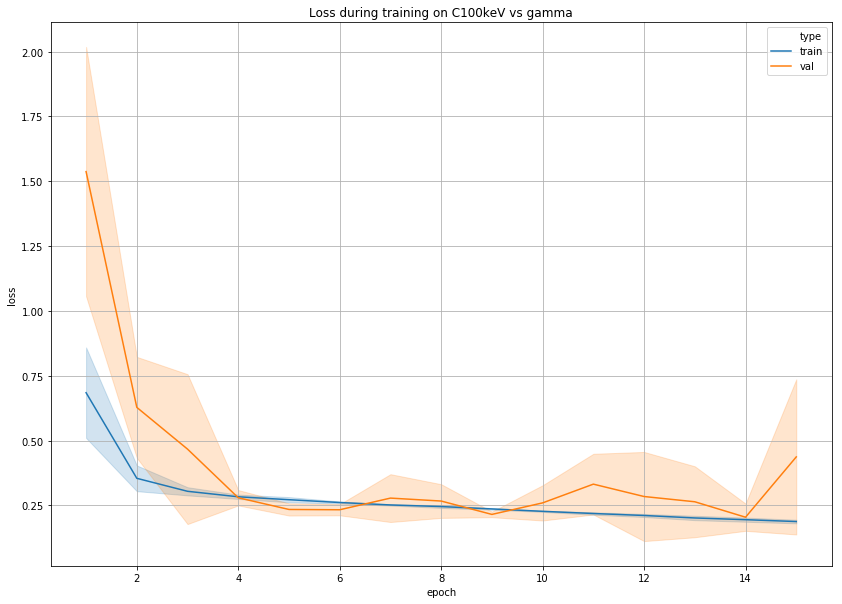

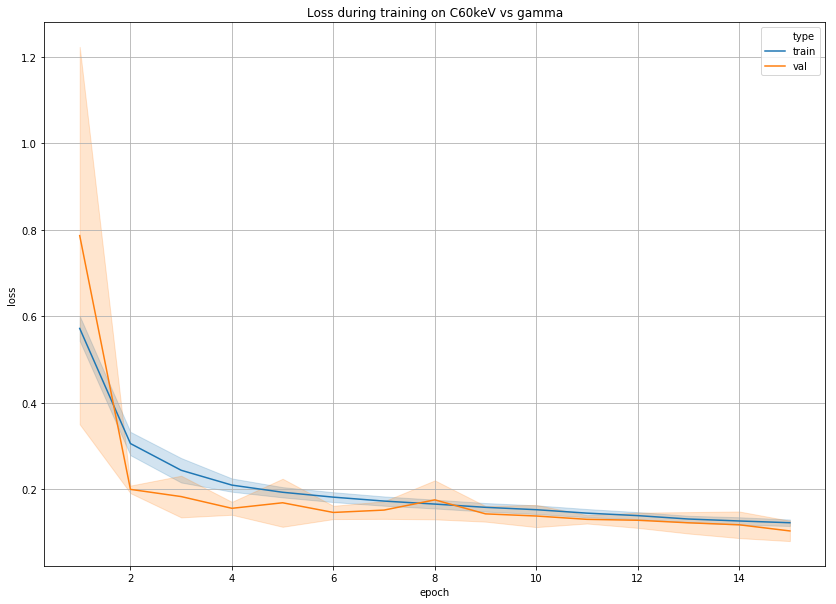

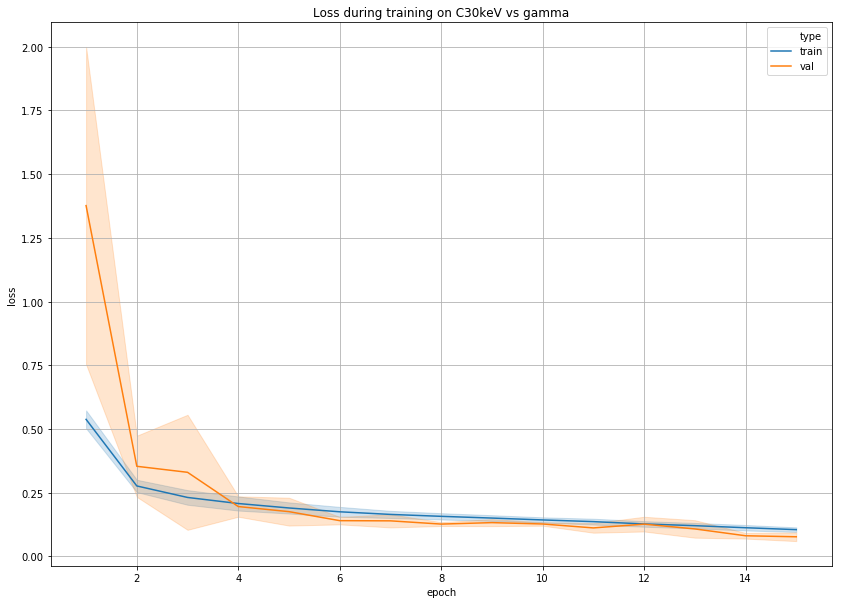

In [8]:
loss = {}
loss['epoch'], loss['type'], loss['loss'], loss['class'] = [],[],[],[]
for n in class_names:
    for s in [k for k in hist.keys() if n in k]:
        e = 1
        for l, vl in zip(hist[s].history['loss'],hist[s].history['val_loss']):
            loss['epoch'].append(e); loss['type'].append('train'); loss['loss'].append(l); loss['class'].append(n)
            loss['epoch'].append(e); loss['type'].append('val'); loss['loss'].append(vl); loss['class'].append(n)
            e += 1
loss = pd.DataFrame(data=loss)

for n in class_names:
    plt.figure(figsize=(14,10))
    sns.lineplot(x='epoch',y='loss',hue='type', data=loss[loss['class']==n], ci='sd')
    plt.grid()
    plt.title('Loss during training on '+n+' vs gamma')
    plt.show()

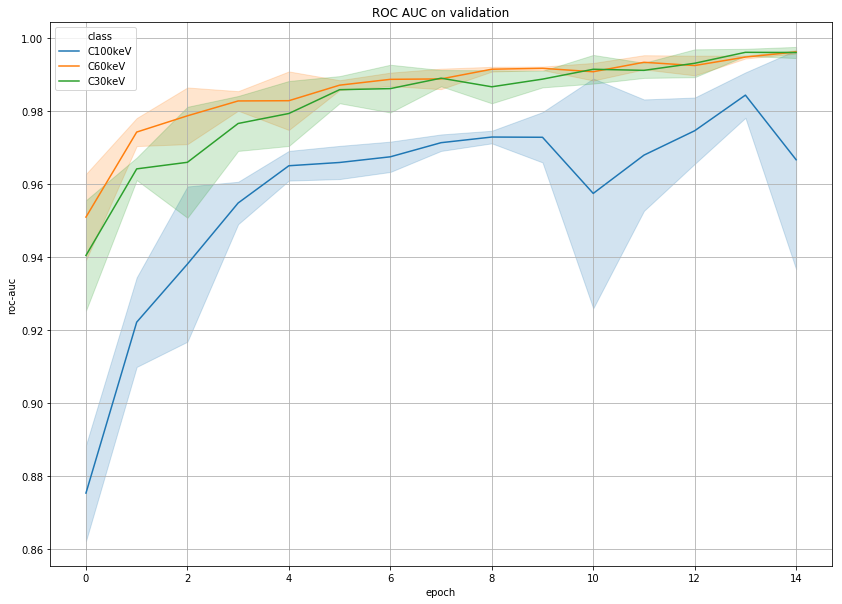

In [9]:
aucs = {}
aucs['epoch'], aucs['roc-auc'], aucs['class'] = [],[],[]
for n in class_names:
    for s in [k for k in hist_roc.keys() if n in k]:
        for e, au in enumerate(hist_roc[s].val_aucs):
            aucs['epoch'].append(e); aucs['roc-auc'].append(au); aucs['class'].append(n)
aucs = pd.DataFrame(data=aucs)

plt.figure(figsize=(14,10))
sns.lineplot(x='epoch',y='roc-auc', hue='class', data=aucs, ci='sd')
plt.grid()
_ = plt.title('ROC AUC on validation')